In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
import datetime as dt
import geopandas as gpd
import plotly.graph_objects as go
import os
from shapely.geometry import Point
import calendar
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

plt.rcParams['font.family'] = "Futura"
plt.rcParams['font.serif'] = ["Futura"]

In [2]:
accident = pd.read_csv("dataset/US_Accidents_March23.csv")
GAaccident = pd.read_csv("dataset/GA_Accidents_March23.csv")

# interactive graph

## state heatmap

In [3]:
state_count_acc = pd.value_counts(accident['State'])

fig = go.Figure(data=go.Choropleth(
    locations=state_count_acc.index,
    z = state_count_acc.values.astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Count Accidents",
))

fig.update_layout(
    title_text = '2016 - 2023 US Traffic Accident Dataset by State',
    geo_scope='usa',
)
# fig.show()
fig.write_html(os.path.join("Interactive", "TrafficHeatmapByState.html"))

## county heatmap 

In [4]:
df_county = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
df_county['county_full'] = df_county['County Name/State Abbreviation'].apply(lambda x: x.split(', ')[0])
df_county['county_name'] = df_county['county_full'].apply(lambda x: x.split(' County')[0])

# county_count_acc = pd.value_counts(accident['County'])
county_count_acc = pd.value_counts(accident['County'])
fips_county_df = df_county[['county_name', 'County FIPS Code', 'State FIPS Code']].merge(county_count_acc, left_on='county_name', right_index=True)
# county_count_acc = pd.value_counts(accident['County'])
county_count_acc = pd.value_counts(accident['County'])
import plotly.figure_factory as ff
fips_county_df['State FIPS Code'] = fips_county_df['State FIPS Code'].apply(lambda x: str(x).zfill(2))
fips_county_df['County FIPS Code'] = fips_county_df['County FIPS Code'].apply(lambda x: str(x).zfill(3))
fips_county_df['FIPS'] = fips_county_df['State FIPS Code'] + fips_county_df['County FIPS Code']

In [40]:

colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]

# colorscale = ["#feedde", "#fdd0a2", "#fdae6b", "#fd8d3c", "#f16913", "#d94801",
#     "#a63603", "#7f2704", "#67001f", "#b2182b", "#d6604d", "#f4a582",
#     "#fddbc7", "#f7f7f7", "#d1e5f0", "#92c5de", "#4393c3", "#2166ac"
# ]

num_colors = 18
# Generate the gradient
colorscale = [
    "#{:02X}{:02X}{:02X}".format(
        int(np.interp(i, [0, num_colors-1], [int("ff", 16), int("00", 16)])),
        int(np.interp(i, [0, num_colors-1], [int("ff", 16), int("bb", 16)])),
        int(np.interp(i, [0, num_colors-1], [int("ff", 16), int("ff", 16)]))
    )
    for i in range(num_colors)
]


endpts = list(np.linspace(1,30000, len(colorscale) - 1))
fips = fips_county_df['FIPS'].tolist()
values = fips_county_df['count'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['Florida'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=True,
    show_hover=True,
    asp = 2.9,
    title_text = 'USA County accidents count',
    legend_title = 'Accidents count'
    # county_outline='red'
)
fig.layout.template = None
fig.show()
fig.write_html(os.path.join("Interactive", "countyHeatmap.html"))

## accident location heat map (Atlanta)

In [6]:
accident1 = accident.groupby(['Start_Lat', 'Start_Lng']).agg({'ID': 'count'}).reset_index().rename(columns={'ID':'count'})
accident1.head()
accident1 = accident1[(accident1.Start_Lat > 33.0) & (accident1.Start_Lat < 34.0) & (accident1.Start_Lng < -84.0) & (accident1.Start_Lng > -85.0)]
fig = px.density_mapbox(accident1, lat = 'Start_Lat', lon = 'Start_Lng', z = 'count',
                        radius = 8,
                        center = dict(lat = 33.77, lon = -84.38),
                        zoom = 6,
                        mapbox_style = 'open-street-map')
fig.write_html(os.path.join("Interactive", "heatmap.html"))
# fig.show()

## severity count

In [7]:
data_sever = accident.sample(n=5000)

fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = data_sever['Start_Lng'],
        lat = data_sever['Start_Lat'],
        text = data_sever['City'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
        colorscale = 'Reds',
        cmin = data_sever['Severity'].max(),
        color = data_sever['Severity'],
        cmax = 1,
        colorbar_title="Severity"
        )))

fig.update_layout(
        title = 'Severity of accidents',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.7,
            subunitwidth = 0.7
        ),
    )
fig.write_html(os.path.join("Interactive", "severity.html"))
fig.show()

## severity by county

In [8]:
# county_severity_acc = accident[['County','Severity']].groupby('County').mean().reset_index()
county_severity_acc = accident[['County','Severity']].groupby('County').mean().reset_index()
fips_county_sev = df_county[['county_name', 'County FIPS Code', 'State FIPS Code']].merge(county_severity_acc, left_on='county_name', right_on='County')
fips_county_sev['Severity'] = fips_county_sev['Severity'].apply(lambda x: round(x,1))
fips_county_sev['State FIPS Code'] = fips_county_sev['State FIPS Code'].apply(lambda x: str(x).zfill(2))
fips_county_sev['County FIPS Code'] = fips_county_sev['County FIPS Code'].apply(lambda x: str(x).zfill(3))
fips_county_sev['FIPS'] = fips_county_sev['State FIPS Code'] + fips_county_sev['County FIPS Code']


fips = fips_county_sev['FIPS'].tolist()
values = fips_county_sev['Severity'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['GA'],
    # binning_endpoints=endpts,
    show_state_data=True,
    # show_hover=True,
    # asp = 2.9,
    title_text = 'USA accidents severity (mean)',
    legend_title = 'Accidents severity'
)
fig.layout.template = None
fig.write_html(os.path.join("Interactive", "severityByCounty.html"))
fig.show()

# static graph

## City rank

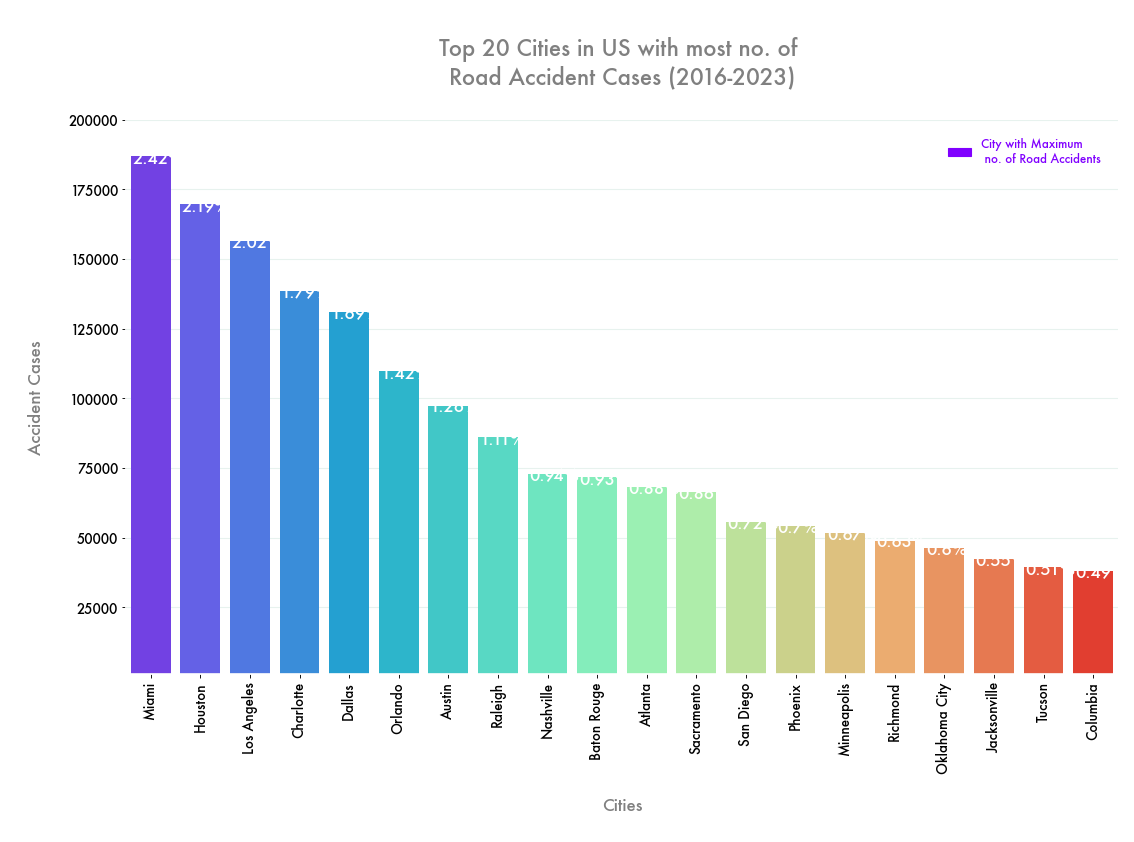

In [9]:
city_df = pd.DataFrame(accident['City'].value_counts()).reset_index().rename(columns={'index':'City', 'count':'Cases'})
top_cities = city_df.head(20)
fig, ax = plt.subplots(figsize = (16,9), dpi = 80)

cmap = cm.get_cmap('rainbow', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=top_cities['Cases'], x=top_cities['City'], palette='rainbow')

total = sum(city_df['Cases'])
for i in ax.patches:
    ax.text(i.get_x()+.03, i.get_height()-2500, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15, weight='bold',
                color='white')

plt.title('\nTop 20 Cities in US with most no. of \nRoad Accident Cases (2016-2023)\n', size=20, color='grey')

plt.ylim(1000, 200000)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

ax.set_xlabel('\nCities\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['bottom', 'left']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)
MA = mpatches.Patch(color=clrs[0], label='City with Maximum\n no. of Road Accidents')
ax.legend(handles=[MA], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=clrs[0], edgecolor='white');
plt.savefig(os.path.join('pics', 'top_cities_rank.png'), bbox_inches='tight')   
plt.show()

## State rank

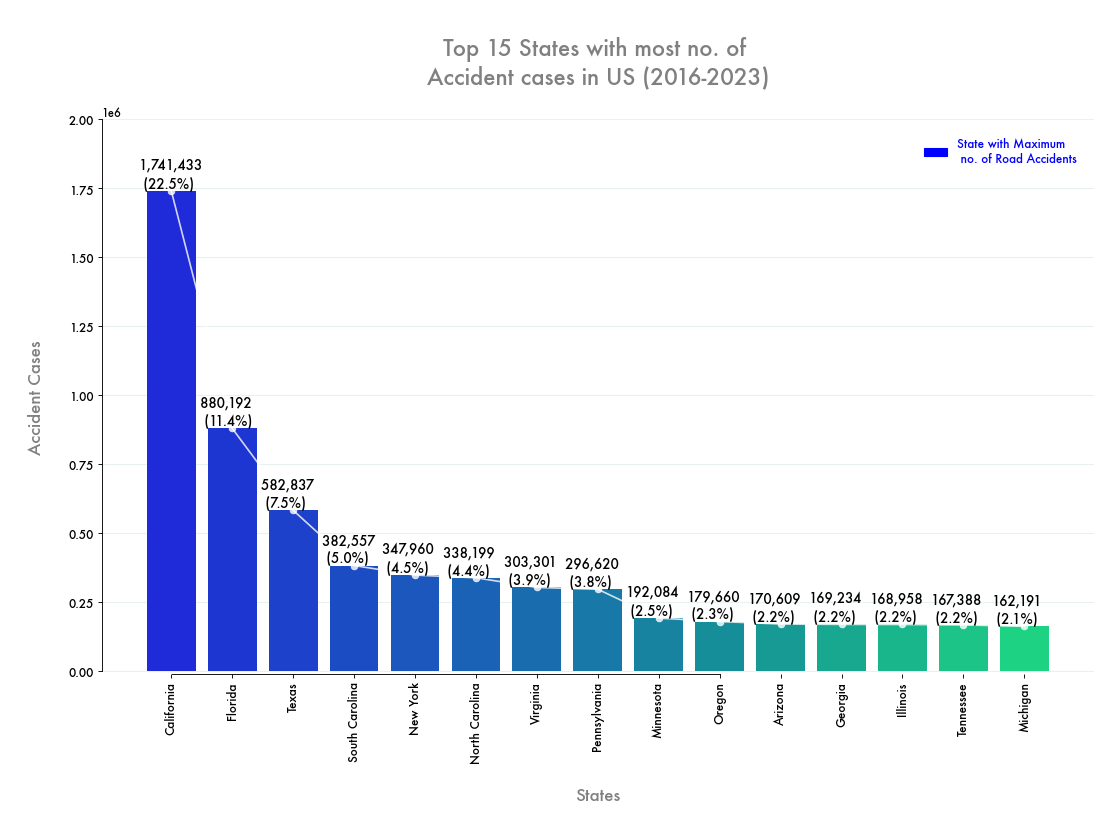

In [10]:
# create a dictionary using US State code and their corresponding Name
us_states = {'AK': 'Alaska',
 'AL': 'Alabama',
 'AR': 'Arkansas',
 'AS': 'American Samoa',
 'AZ': 'Arizona',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'District of Columbia',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'GU': 'Guam',
 'HI': 'Hawaii',
 'IA': 'Iowa',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MA': 'Massachusetts',
 'MD': 'Maryland',
 'ME': 'Maine',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MO': 'Missouri',
 'MP': 'Northern Mariana Islands',
 'MS': 'Mississippi',
 'MT': 'Montana',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'NE': 'Nebraska',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NV': 'Nevada',
 'NY': 'New York',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'PR': 'Puerto Rico',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VA': 'Virginia',
 'VI': 'Virgin Islands',
 'VT': 'Vermont',
 'WA': 'Washington',
 'WI': 'Wisconsin',
 'WV': 'West Virginia',
 'WY': 'Wyoming'}

# create a dataframe of State and their corresponding accident cases
state_df = pd.DataFrame(accident['State'].value_counts()).reset_index().rename(columns={'count':'Cases'})


# Function to convert the State Code with the actual corressponding Name
def convert(x): return us_states[x]

# state_df['State'] = state_df['State'].apply(convert)
state_df['State'] = state_df['State'].map(us_states)



top_ten_states_name = list(state_df['State'].head(15))


fig, ax = plt.subplots(figsize = (16,9), dpi = 80)

cmap = cm.get_cmap('winter', 15)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=state_df['Cases'].head(15), x=state_df['State'].head(15), palette='winter')
# ax1 = ax.twinx()
sns.lineplot(data = state_df[:15], marker='o', x='State', y='Cases', color = 'white', alpha = .8)


total = accident.shape[0]
for i in ax.patches:
    ax.text(i.get_x()-0.2, i.get_height()+10000, \
            ' {:,d}\n  ({}%) '.format(int(i.get_height()), round(100*i.get_height()/total, 1)), fontsize=12,
                color='black')


ax.set(ylim =(-10000, 2000000))
# ax1.set(ylim =(-100000, 1700000))

plt.title('\nTop 15 States with most no. of \nAccident cases in US (2016-2023)\n', size=20, color='grey')
# ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nStates\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['top','right']:
    side1 = ax.spines[i]
    side1.set_visible(False)
    # side2 = ax1.spines[i]
    # side2.set_visible(False)
    
ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)

ax.spines['bottom'].set_bounds(0.005, 9)
ax.spines['left'].set_bounds(0, 2000000)
# ax1.spines['bottom'].set_bounds(0.005, 9)
# ax1.spines['left'].set_bounds(0, 2000000)
ax.tick_params(axis='y', which='major', labelsize=10.6)
ax.tick_params(axis='x', which='major', labelsize=10.6, rotation=90)

MA = mpatches.Patch(color=clrs[0], label='State with Maximum\n no. of Road Accidents')
ax.legend(handles=[MA], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=clrs[0], edgecolor='white')
plt.savefig(os.path.join('pics', 'top_states_rank.png'), bbox_inches='tight')
plt.show()

## street analysis

In [11]:
# create a dataframe of Street and their corresponding accident cases
street_df = pd.DataFrame(accident['Street'].value_counts()).reset_index().rename(columns={'Street':'Street No.', 'count':'Cases'})

In [12]:
street_df

Street No.  Cases
0                     I-95 N  78430
1                     I-95 S  74528
2                      I-5 N  71968
3                     I-10 E  55572
4                     I-10 W  53725
...                      ...    ...
336301   W Diamond Valley Dr      1
336302           S Jasper St      1
336303         State RT 17 N      1
336304   S Lake Mary Jane Rd      1
336305     473-401 Cutoff Rd      1

[336306 rows x 2 columns]

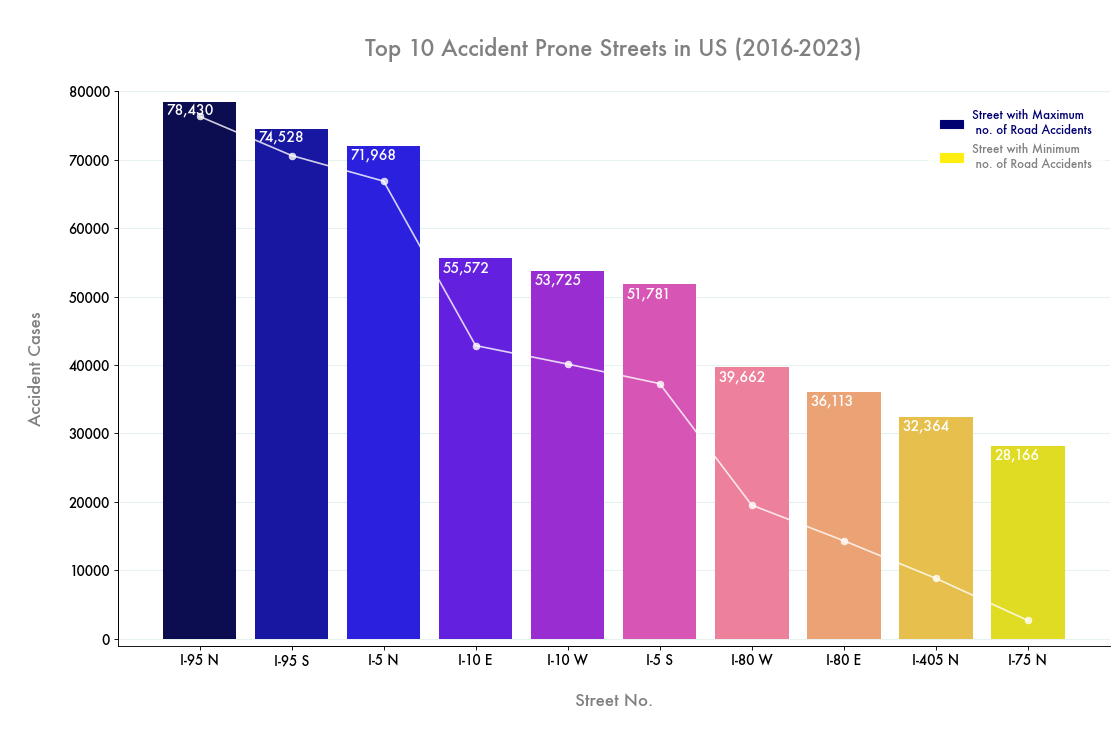

In [13]:
top_ten_streets_df = pd.DataFrame(street_df.head(10))
fig, ax = plt.subplots(figsize = (16,9), dpi = 80)
        
cmap = cm.get_cmap('gnuplot2', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=top_ten_streets_df['Cases'], x=top_ten_streets_df['Street No.'], palette='gnuplot2')
ax1 = ax.twinx()
sns.lineplot(data = top_ten_streets_df, marker='o', x='Street No.', y='Cases', color = 'white', alpha = .8)

total = accident.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.04, i.get_height()-2000, \
            '{:,d}'.format(int(i.get_height())), fontsize=12.5,weight='bold',
                color='white')
    
ax.axes.set_ylim(-1000, 80000)
# ax1.axes.set_ylim(-1000, 40000)
plt.title('\nTop 10 Accident Prone Streets in US (2016-2023)\n', size=20, color='grey')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nStreet No.\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['top','right']:
    side1 = ax.spines[i]
    side1.set_visible(False)
    side2 = ax1.spines[i]
    side2.set_visible(False)

    
ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)

ax.spines['bottom'].set_bounds(0.005, 9)
ax.spines['left'].set_bounds(0, 80000)
# ax1.spines['bottom'].set_bounds(0.005, 9)
# ax1.spines['left'].set_bounds(0, 30000)
ax.tick_params(axis='both', which='major', labelsize=12)

MA = mpatches.Patch(color=clrs[1], label='Street with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color=clrs[-2], label='Street with Minimum\n no. of Road Accidents')
ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=[clrs[1], 'grey'], edgecolor='white')
plt.savefig(os.path.join('pics', 'top_street_rank.png'), bbox_inches='tight')
plt.show()

## accident duration analysis

In [14]:
accident['Start_Time'] = accident['Start_Time'].apply(lambda x: x[:19])
accident['End_Time'] = accident['End_Time'].apply(lambda x: x[:19])

accident['Start_Time']=pd.to_datetime(accident['Start_Time'])
accident['End_Time']=pd.to_datetime(accident['End_Time'])

In [15]:

accident_duration_df = pd.DataFrame(accident['End_Time'] - accident['Start_Time']).reset_index().rename(columns={'index':'Id', 0:'Duration'})
top_10_accident_duration_df = pd.DataFrame(accident_duration_df['Duration'].value_counts().head(10).sample(frac = 1)).reset_index().rename(columns={'count':'Cases'}).sort_values(by = 'Duration', ascending=False)
top_10_accident_duration_df

Duration   Cases
4 0 days 06:00:00  369307
7 0 days 04:00:00   57317
3 0 days 01:15:00   61374
0 0 days 01:00:00   61173
2 0 days 00:45:00   70075
8 0 days 00:30:00  116096
6 0 days 00:29:47   55058
1 0 days 00:29:46   55955
5 0 days 00:29:45   56112
9 0 days 00:29:44   54369

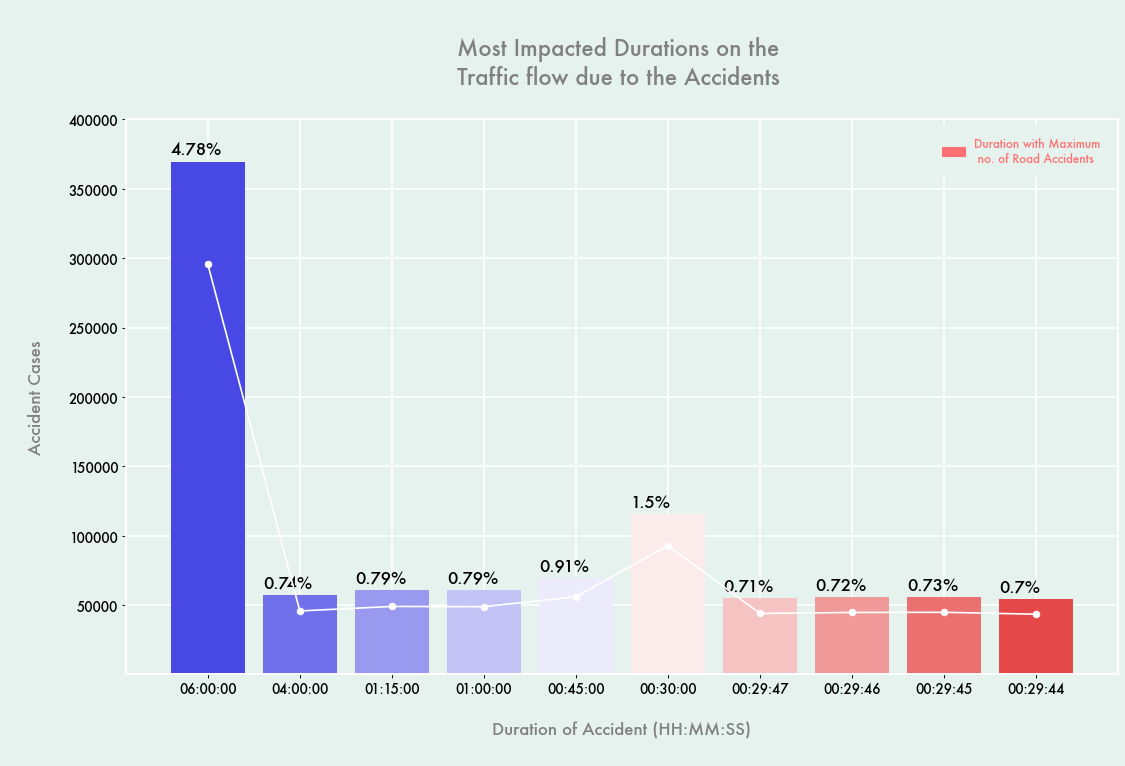

In [16]:


Duration = [str(i).split('days')[-1].strip() for i in top_10_accident_duration_df.Duration]

top_10_accident_duration_df['Duration'] = Duration

fig, ax = plt.subplots(figsize = (16,9), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')


cmap = cm.get_cmap('bwr', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=top_10_accident_duration_df['Cases'], x=top_10_accident_duration_df['Duration'], palette='bwr')
ax1 = ax.twinx()
sns.lineplot(data = top_10_accident_duration_df, marker='o', x='Duration', y='Cases', color = 'white', alpha = 1)

total = accident.shape[0]
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+5000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='black')

ax.set(ylim =(1000, 400000))
ax1.set(ylim =(1000, 500000))

plt.title('\nMost Impacted Durations on the \nTraffic flow due to the Accidents \n', size=20, color='grey')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nDuration of Accident (HH:MM:SS)\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    ax1.spines[i].set_color('white')
    ax1.spines[i].set_linewidth(1.5)
    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5)
ax.tick_params(axis='both', which='major', labelsize=12)
MA = mpatches.Patch(color=clrs[-3], label='Duration with Maximum\n no. of Road Accidents')
ax.legend(handles=[MA], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=clrs[-3], facecolor='#e6f2ed', edgecolor='#e6f2ed')
plt.savefig(os.path.join('pics', 'duration_rank.png'), bbox_inches='tight')
plt.show()

## Year analysis

In [17]:
year_df = pd.DataFrame(accident.Start_Time.dt.year.value_counts()).reset_index().rename(columns={'count':'Cases', 'Start_Time':'Year'}).sort_values(by='Year', ascending=True)
year_df

Year    Cases
6  2016   410821
5  2017   718093
4  2018   893426
3  2019   954303
2  2020  1178913
1  2021  1563753
0  2022  1762452
7  2023   246633

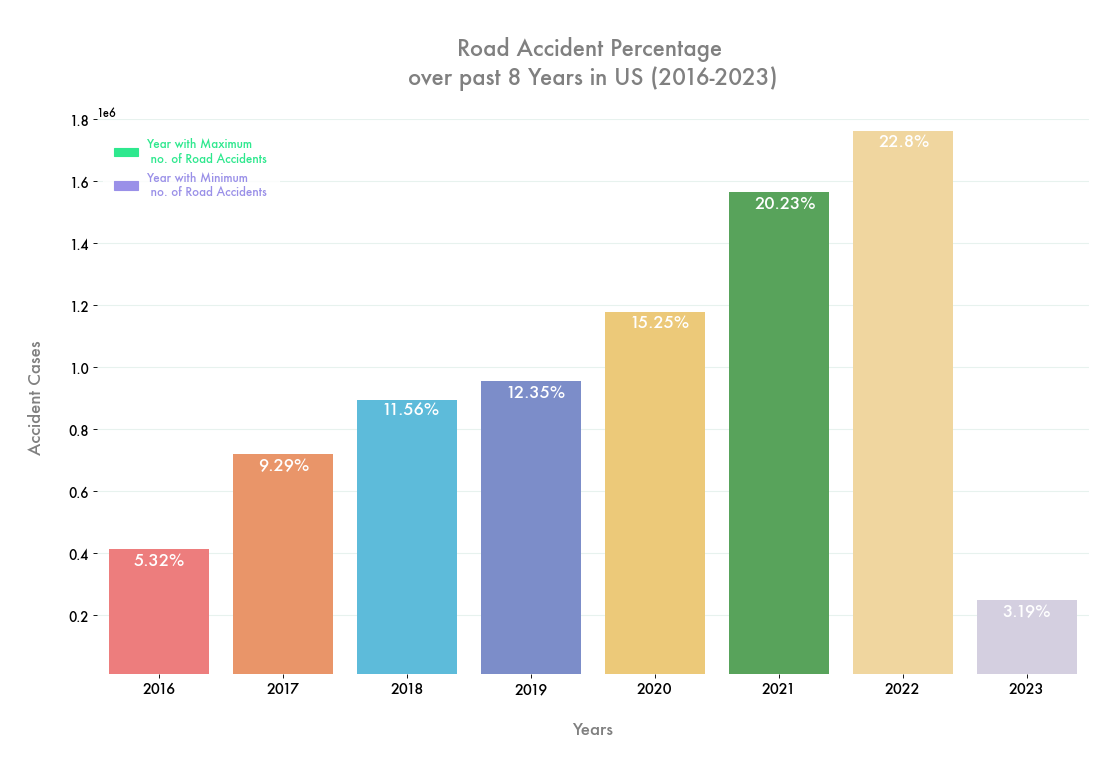

In [18]:

fig, ax = plt.subplots(figsize = (16,9), dpi = 80)

ax=sns.barplot(y=year_df['Cases'], x=year_df['Year'], palette=["#FF6B6B","#FF8E53","#48C6EF","#6F86D6","#FFD166","#4CAF50","#FDDB92","#D3CCE3"])

total = accident.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.2, i.get_height()-50000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,weight='bold',
                color='white')

plt.ylim(10000, 1800000)
plt.title('\nRoad Accident Percentage \nover past 8 Years in US (2016-2023)\n', size=20, color='grey')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.xlabel('\nYears\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    

for k in ['top', 'right', "bottom", 'left']:
        side = ax.spines[k]
        side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=0.3)
MA = mpatches.Patch(color='#2ee88e', label='Year with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color='#9a90e8', label='Year with Minimum\n no. of Road Accidents')
ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=['#2ee88e', '#9a90e8'], edgecolor='white')
plt.savefig(os.path.join('pics', 'accident_over_year.png'), bbox_inches='tight')
plt.show()

## year analysis based on severity

In [19]:
geometry = [Point(xy) for xy in zip(accident['Start_Lng'], accident['Start_Lat'])]
geo_df = gpd.GeoDataFrame(accident, geometry=geometry)

geo_df['year'] = geo_df.Start_Time.dt.year
geo_df['State'] = geo_df['State'].apply(convert)


225.0 0.5
282.0 0.5
259.0 0.5
203.0 0.5
28371.0 0.5
151.0 0.5
37875.0 0.5
0.0 0.5
270026.0 0.5
462474.0 0.5
574668.0 0.5
688144.0 0.5
934123.0 0.5
1384628.0 0.5
1603346.0 0.5
239572.0 0.5
126215.0 0.5
231169.0 0.5
292706.0 0.5
237853.0 0.5
185352.0 0.5
148085.0 0.5
77957.0 0.5
0.0 0.5
14355.0 0.5
24168.0 0.5
25793.0 0.5
28103.0 0.5
31067.0 0.5
30889.0 0.5
43274.0 0.5
7061.0 0.5


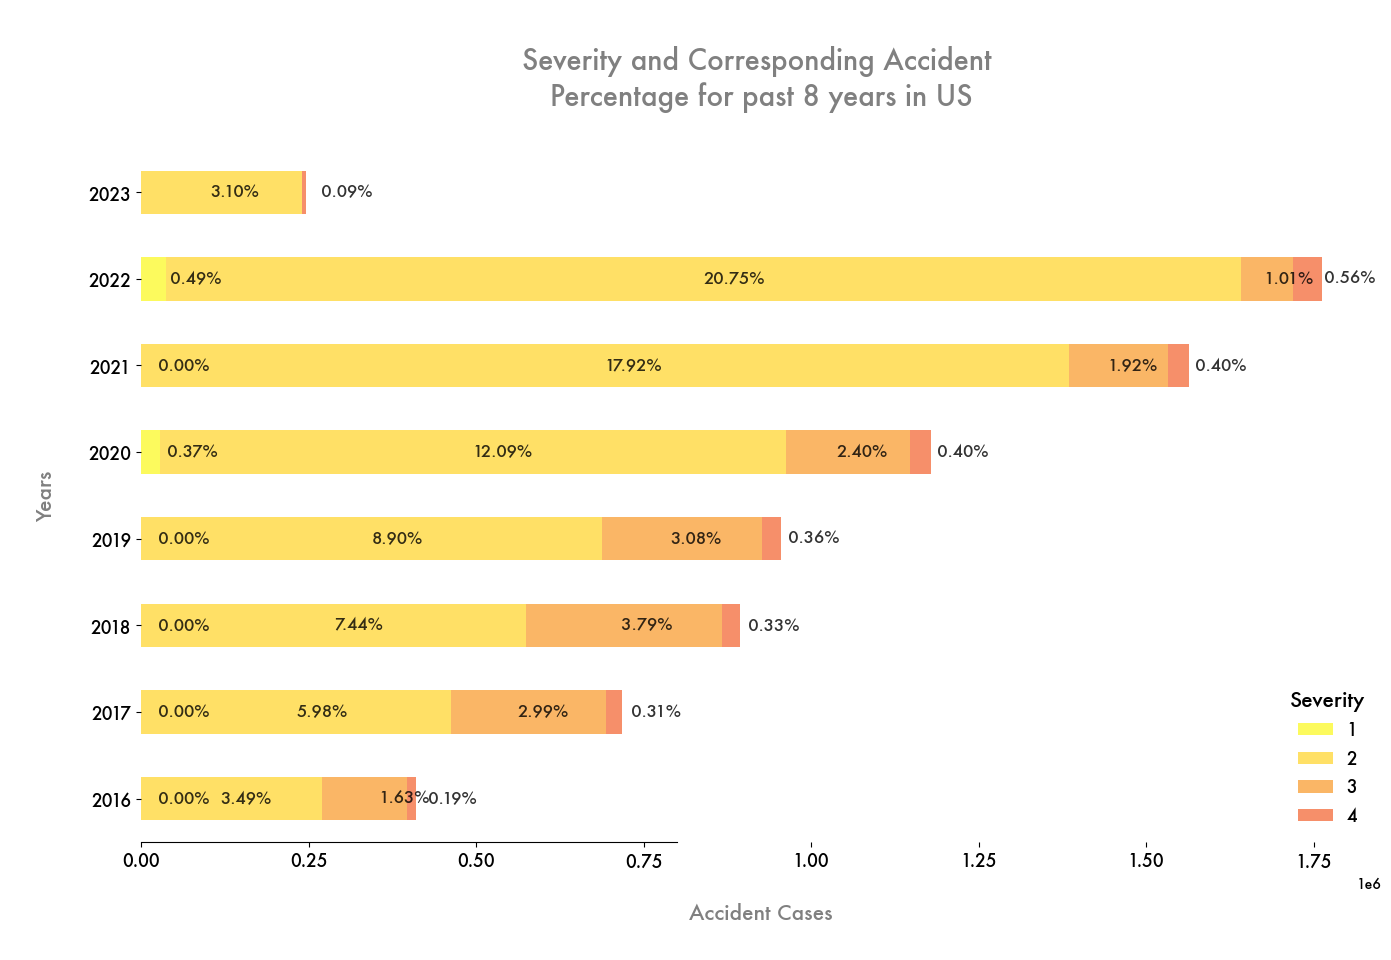

In [20]:

accident_severity_df = geo_df.groupby(['year', 'Severity']).size().unstack()

ax = accident_severity_df.plot(kind='barh', stacked=True, figsize=(16, 9), 
                               color=['#fcfa5d', '#ffe066', '#fab666', '#f68f6a'],
                               rot=0)

ax.set_title('\nSeverity and Corresponding Accident \nPercentage for past 8 years in US\n', fontsize=20, color='grey')

for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
ax.spines['bottom'].set_bounds(0, 800000)
ax.set_ylabel('\nYears\n', fontsize=15, color='grey')
ax.set_xlabel('\nAccident Cases\n', fontsize=15, color='grey')
ax.legend(prop={'size': 12.5}, loc='best', fancybox = True, title="Severity", title_fontsize=15, edgecolor='white')
ax.tick_params(axis='both', which='major', labelsize=12.5)
#ax.set_facecolor('#e6f2ed')
    
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    print(width, height)
    x, y = p.get_xy()
    var = width*100/accident.shape[0]
    if var > 0:
        if var > 4:
            ax.text(x+width/2, 
                        y+height/2-0.05, 
                        '{:.2f}%'.format(width*100/accident.shape[0]),
                        fontsize=12,  color='black', alpha= 0.8)
        elif var > 1.8 and var < 3.5:
            ax.text(x+width/2-17000, 
                        y+height/2-0.05, 
                        '{:.2f}%'.format(width*100/accident.shape[0]),
                        fontsize=12,  color='black', alpha= 0.8)      
        elif var>1.5 and var<1.8:
            ax.text(x+width/2+7000, 
                    y+height/2-0.05, 
                    '  {:.2f}%'.format(width*100/accident.shape[0]),
                    fontsize=12,  color='black', alpha= 0.8)
        elif var>1:
            ax.text(x+width/2-20000, 
                    y+height/2-0.05, 
                    '  {:.2f}%'.format(width*100/accident.shape[0]),
                    fontsize=12,  color='black', alpha= 0.8)
        else:
            ax.text(x+width/2+10000, 
                    y+height/2-0.05, 
                    '  {:.2f}%'.format(width*100/accident.shape[0]),
                    fontsize=12,  color='black', alpha= 0.8)

# Save the plot as an image (adjust the filename and format as needed)
plt.savefig(os.path.join('pics','accident_severity_plot.png'), bbox_inches='tight')

# Show the plot
plt.show()

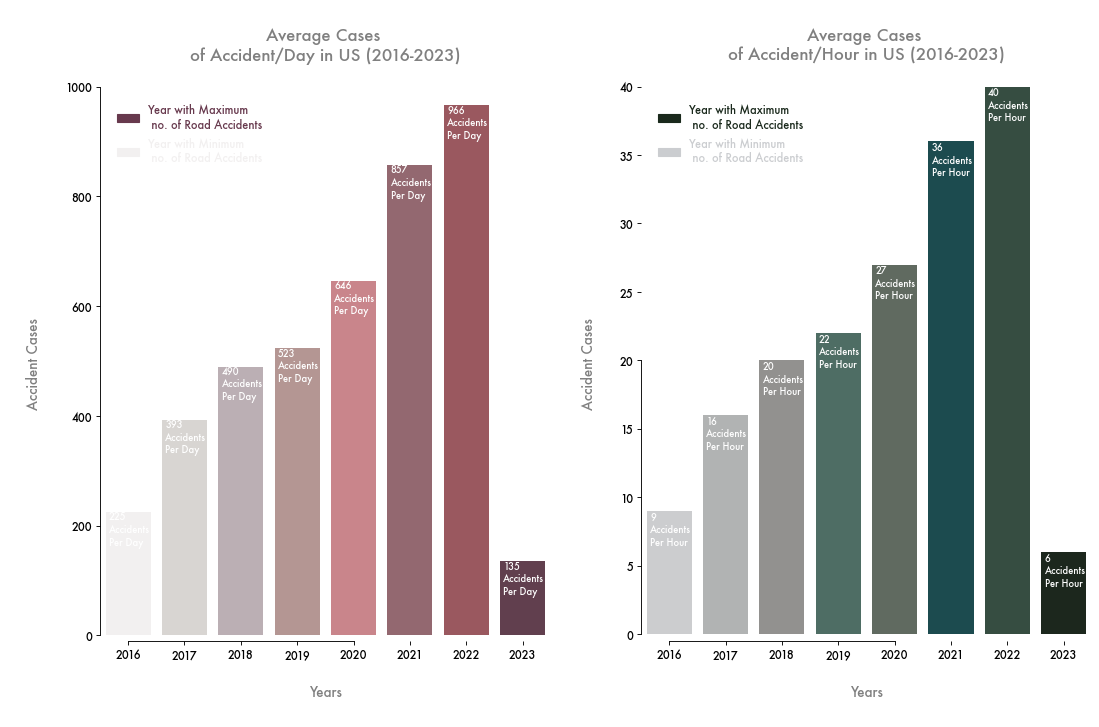

In [21]:
year_df['accident/day'] = round(year_df['Cases']/(5*365))
year_df['accident/hour'] = round(year_df['Cases']/(5*365*24))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,9), dpi = 80)

count = 0
plots = ['accident/day', 'accident/hour']
plots_limit = [(-10, 1000), (-0.5, 40)]
plots_bound = [(0, 1000), (0, 20)]
plot_text = [60, 2.5]

colors = [['#ffb74b', '#ffd6a4', '#ceb1f2', '#a071ff', '#6f71f7'], 
          ['#cd7cf2', '#f27ec8', '#fa70b3', '#ff5e86', '#ff1732']]

colors = [['#f2f0f0','#d9d5d1','#bdadb4','#b9928e','#d47a81','#9a616b','#a54d57','#67394d'],
          ['#cbcdd0','#b1b3b3','#93918e','#497266','#5e6c5e','#135257','#325141','#1a291c']]

for i in [ax1, ax2]:

    sns.barplot(ax=i, y=year_df[plots[count]], x=year_df['Year'], palette=colors[count])
    
    var = plots[count].split('/')[-1].capitalize()
    
    for j in i.patches:
        i.text(j.get_x()+0.06, j.get_height()-plot_text[count], \
                str(int(j.get_height()))+'\nAccidents\nPer {}'.format(var), fontsize=8.5, color='white', weight='bold')

    i.axes.set_ylim(plots_limit[count])
    i.axes.set_ylabel('\nAccident Cases\n', fontsize=12, color='grey')
    i.axes.set_xlabel('\nYears\n', fontsize=12, color='grey')
    i.tick_params(axis='both', which='major', labelsize=10)

    i.set_title('\nAverage Cases \nof Accident/{} in US (2016-2023)\n'.format(var), fontsize =15, color='grey')
    i.spines['bottom'].set_bounds(0.005, 4)
    i.spines['left'].set_bounds(plots_bound[count])

    for k in ['top', 'right']:
            side = i.spines[k]
            side.set_visible(False)

    i.set_axisbelow(True)
    MA = mpatches.Patch(color=colors[count][-1], label='Year with Maximum\n no. of Road Accidents')
    MI = mpatches.Patch(color=colors[count][0], label='Year with Minimum\n no. of Road Accidents')
    i.legend(handles=[MA, MI], prop={'size': 10}, loc='best', borderpad=1, 
          labelcolor=[colors[count][-1], colors[count][0]], edgecolor='white')
    count += 1
    
# Save the plot as an image (adjust the filename and format as needed)
plt.savefig(os.path.join('pics','accident_average_cases_plot.jpg'), bbox_inches='tight')

# Show the plot
plt.show()

## Month analysis

In [22]:
month_df = pd.DataFrame(accident.Start_Time.dt.month.value_counts()).reset_index().rename(columns={'Start_Time':'Month', 'count':'Cases'}).sort_values(by = 'Month')

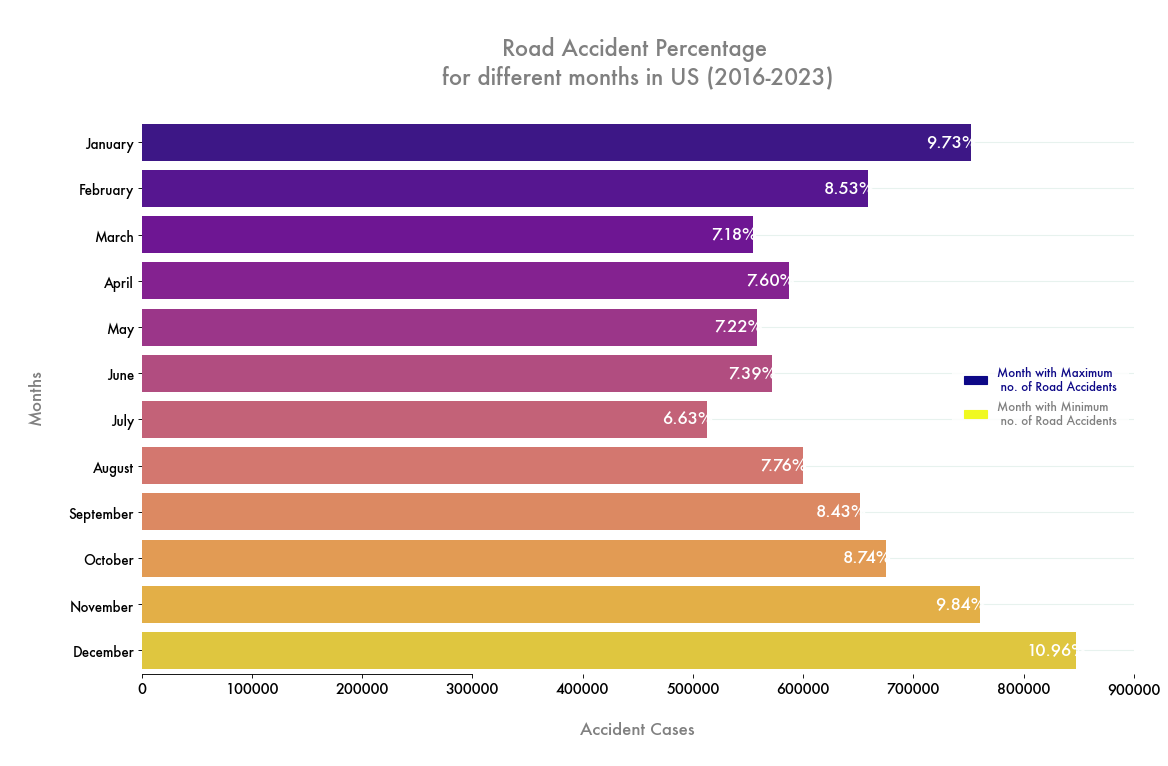

In [23]:

month_names = list(calendar.month_name)[1:]
month_df.Month = month_names

fig, ax = plt.subplots(figsize = (16,9), dpi = 80)

cmap = cm.get_cmap('plasma', 12)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(x=month_df['Cases'], y=month_df['Month'], palette='plasma')

total = accident.shape[0]
for p in ax.patches:
    plt.text(p.get_width()-17000, p.get_y()+0.4,
            '{:.2f}%'.format(p.get_width()*100/total),ha='center', va='center', fontsize=15, color='white', weight='bold')

plt.title('\nRoad Accident Percentage \nfor different months in US (2016-2023)\n', size=20, color='grey')
plt.xlabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.ylabel('\nMonths\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.xlim(0, 900000)

for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

ax.set_axisbelow(True)
ax.spines['bottom'].set_bounds(0, 300000)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)

MA = mpatches.Patch(color=clrs[0], label='Month with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color=clrs[-1], label='Month with Minimum\n no. of Road Accidents')

ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=[clrs[0], 'grey'], edgecolor='white')

# Save the plot as an image (adjust the filename and format as needed)
plt.savefig(os.path.join('pics','accident_month_percentage.jpg'), bbox_inches='tight')

# Show the plot
plt.show()

## Day analysis

In [24]:
day_df = pd.DataFrame(accident.Start_Time.dt.day_name().value_counts()).reset_index().rename(columns={'Start_Time':'Day', 'count':'Cases'})

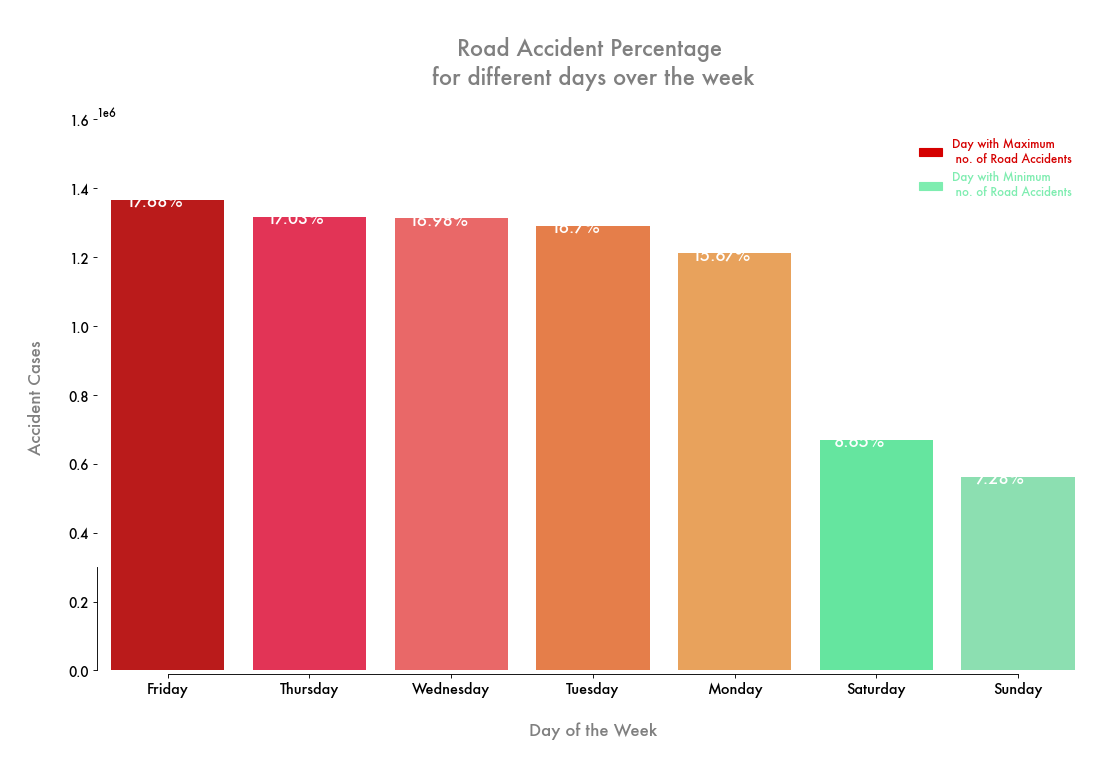

In [25]:
fig, ax = plt.subplots(figsize = (16,9), dpi = 80)

ax=sns.barplot(y=day_df['Cases'], x=day_df['Day'], palette=['#D50000', '#FF1744', '#FF5252', '#ff7530', '#ffa245', '#50fa9d', '#7eedb0'])

total = accident.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()-20000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,weight='bold',
                color='white')

plt.ylim(-10000, 1600000)
plt.title('\nRoad Accident Percentage \nfor different days over the week\n', size=20, color='grey')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.xlabel('\nDay of the Week\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
ax.set_axisbelow(True)
ax.spines['bottom'].set_bounds(0.005, 6)
ax.spines['left'].set_bounds(0, 300000)

MA = mpatches.Patch(color='#D50000', label='Day with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color='#7eedb0', label='Day with Minimum\n no. of Road Accidents')

ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, edgecolor='white', labelcolor=['#D50000', '#7eedb0'])

# Save the plot as an image (adjust the filename and format as needed)
plt.savefig(os.path.join('pics','accident_weekday_percentage.jpg'), bbox_inches='tight')

# Show the plot
plt.show()


## Hour Analysis

In [26]:
hour_df = pd.DataFrame(accident.Start_Time.dt.hour.value_counts()).reset_index().rename(columns={'Start_Time':'Hours', 'count':'Cases'}).sort_values(by = 'Hours')

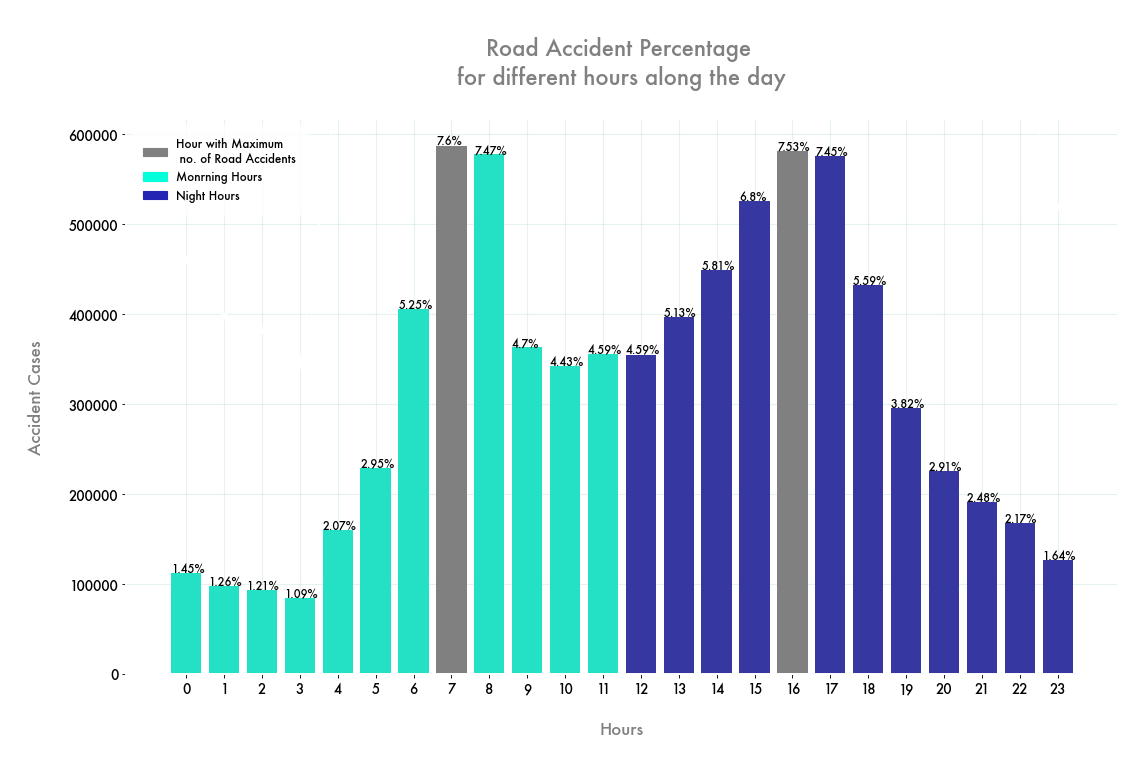

In [27]:
fig, ax = plt.subplots(figsize = (16,9), dpi = 80)

clrs = []
for x in hour_df['Cases']:
    if int(hour_df[hour_df['Cases']==x]['Hours']) <= 11:
        if (x == max(list(hour_df['Cases'])[:12])):
            clrs.append('grey')
        else:
            clrs.append('#05ffda')
    else:
        if (x == max(list(hour_df['Cases'])[12:])):
            clrs.append('grey')
        else:
            clrs.append('#2426b3')
ax=sns.barplot(y=hour_df['Cases'], x=hour_df['Hours'], palette=clrs)
ax1 = ax.twinx()

sns.lineplot(data = hour_df, marker='o', x='Hours', y='Cases', color = 'white', alpha = 1)

total = accident.shape[0]
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+1000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10,
                color='black')

plt.ylim(1000, 150000)
plt.title('\nRoad Accident Percentage \nfor different hours along the day\n', size=20, color='grey')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nHours\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    ax1.spines[i].set_color('white')
    ax1.spines[i].set_linewidth(1.5)
    
ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, alpha=.3)
ax.tick_params(axis='both', which='major', labelsize=12)

MA = mpatches.Patch(color='grey', label='Hour with Maximum\n no. of Road Accidents')
MO = mpatches.Patch(color='#05ffda', label='Monrning Hours')
NI = mpatches.Patch(color='#2426b3', label='Night Hours')

ax.legend(handles=[MA, MO, NI], prop={'size': 10.5}, loc='upper left', borderpad=1, edgecolor='white')

# Save the plot as an image (adjust the filename and format as needed)
plt.savefig(os.path.join('pics','accident_hour_percentage.jpg'), bbox_inches='tight')

# Show the plot
plt.show()

## Weather Analysis

In [28]:
def generate_intervals_labels(attribute, split, gap):
    var_min = min(accident[attribute].dropna())
    intervals = [int(var_min)]
    labels = []
    for i in range(1, split+1):
        
        lower_limit = int(var_min+((i-1)*gap))
        
        if i==split:
            upper_limit = int(max(accident[attribute].dropna()))
        else:
            upper_limit = int(var_min + (i*gap))
            
        #intervals
        intervals.append(upper_limit)
        
        # labels
        label_var = '({} to {})'.format(lower_limit, upper_limit)
        labels.append(label_var)    
    
    return intervals, labels

In [29]:
def Feature_Bin_Plot(dataframe, attribute, clrs, intervals, labels, fig_size, font_size, y_lim, adjust, title):
    
    new_df = dataframe.copy()
    new_df.dropna(subset = [attribute])
    xlabel = 'Different {} Grouped Value'.format(attribute)
    new_df[xlabel] = pd.cut(x = new_df[attribute], bins = intervals, labels = labels, include_lowest=True)
    print(xlabel)
    temp_df = pd.DataFrame(new_df[xlabel].value_counts()).reset_index().rename(columns={xlabel:'Bins', 'count':'Cases'}).sort_values('Bins')
    print(temp_df.columns)
    
    count,max_index = 0, 0
    cases_list = list(temp_df['Cases'])
    for i in cases_list:
        if i == max(temp_df['Cases']):
            max_index = count
            break
        count += 1
                                                                                               
    total = len(new_df[xlabel])
    plt.figure(figsize=fig_size)
    
#     clrs = ['mediumspringgreen' if (x < max(temp_df['Cases'])) else 'grey' for x in temp_df['Cases']]
    cmap = cm.get_cmap(clrs, len(intervals))   
    clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
    
    ax=sns.barplot(y=temp_df['Cases'], x=temp_df['Bins'], palette=clrs)
    
    for i in ax.patches:
        ax.text(i.get_x()+adjust[0], i.get_height()+adjust[-1], \
            '{:,d}\nCases\n({}%) '.format(int(i.get_height()), round(100*i.get_height()/total, 2)), fontsize=font_size,
                color='black')
        
    plt.title(title, size=20, color='grey')
    plt.ylim(y_lim)
    
    for i in ['bottom', 'top', 'left', 'right']:
        ax.spines[i].set_color('white')
        ax.spines[i].set_linewidth(1.5)
        
    ax.set_xlabel('\n{}\n'.format(xlabel), fontsize=15, color='grey')
    ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')
    
    ax.set_axisbelow(True)
    ax.grid(color='#b2d6c7', linewidth=1, alpha=.3)
    ax.tick_params(axis='both', which='major', labelsize=12)
    MA = mpatches.Patch(color=clrs[max_index], label='{} Range with Maximum\n no. of Road Accidents'.format(attribute))
    ax.legend(handles=[MA], prop={'size': 10.5}, loc='best', borderpad=1, 
              labelcolor=[clrs[max_index]], edgecolor='white')
    # Save the plot as an image (adjust the filename and format as needed)
    figname = title.replace("\nPercentage of different ", "").replace(" range\n", "") + '.jpg'
    print(figname)
    plt.savefig(os.path.join('pics',figname), bbox_inches='tight')

    # Show the plot
    plt.show()

Different Temperature(F) Grouped Value
Index(['Bins', 'Cases'], dtype='object')
Temperature.jpg


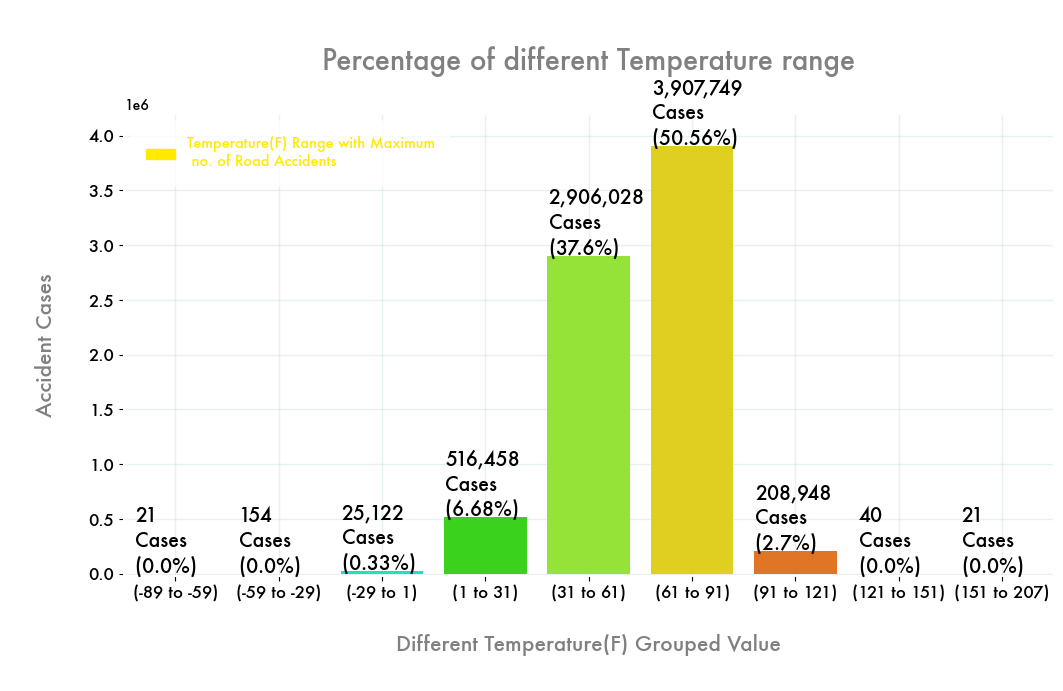

In [30]:
temp_intervals, temp_labels = generate_intervals_labels('Temperature(F)', 9, 30)

Feature_Bin_Plot(accident, 'Temperature(F)', 'gist_ncar',temp_intervals, temp_labels, 
                 (12, 6), 14, (-20000, 4200000), [0.01, 10000], '\nPercentage of different Temperature range\n')

Different Humidity(%) Grouped Value
Index(['Bins', 'Cases'], dtype='object')
Humidity.jpg


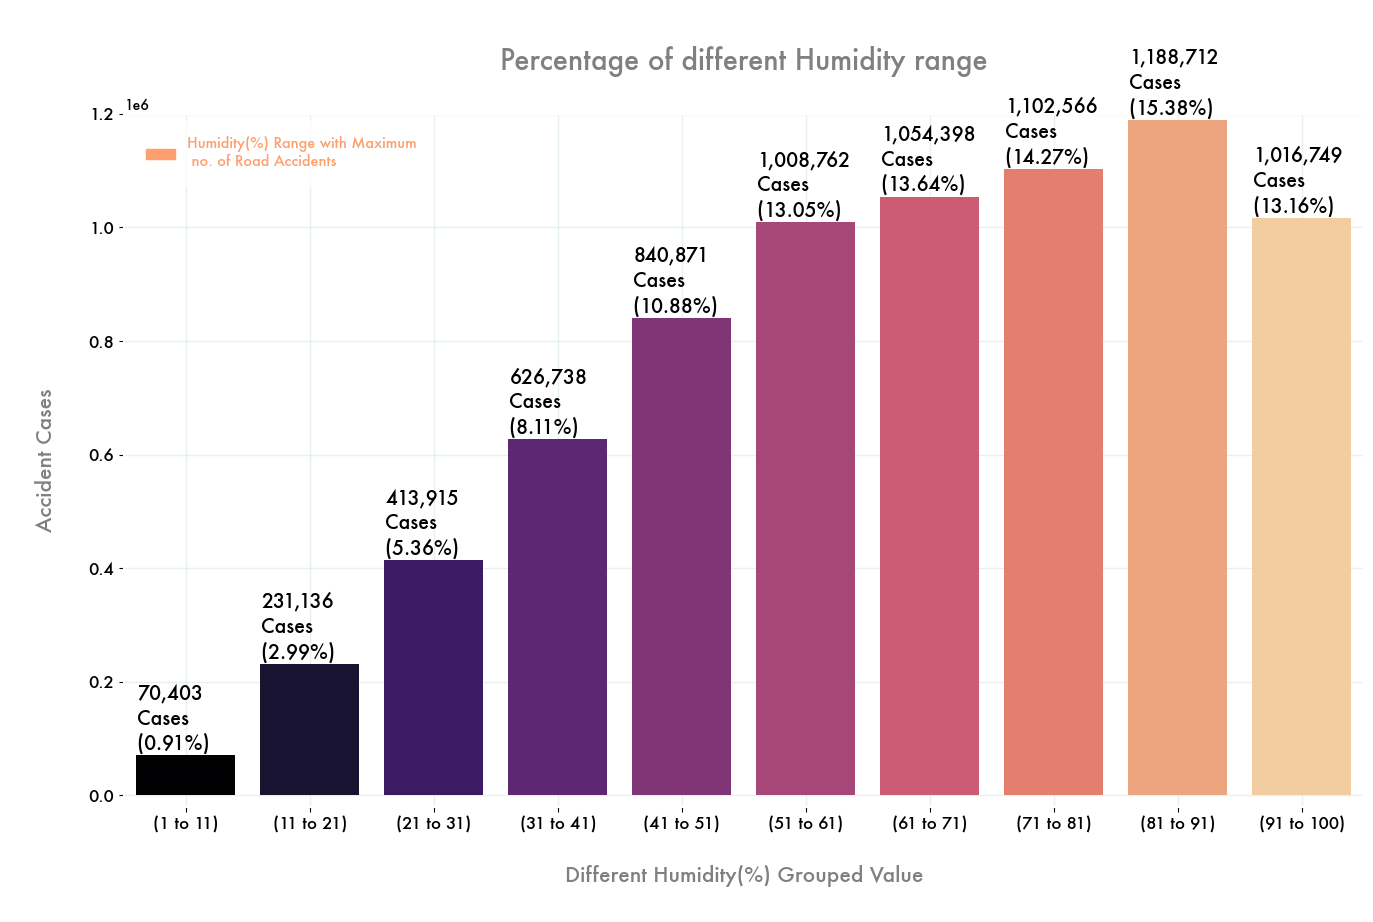

In [31]:
Humidity_intervals, Humidity_labels = generate_intervals_labels('Humidity(%)', 10, 10)

Feature_Bin_Plot(accident, 'Humidity(%)', 'magma', Humidity_intervals, Humidity_labels, 
                 (16, 9), 14, (-20000, 1200000), [0.01, 10000], '\nPercentage of different Humidity range\n')

Different Pressure(in) Grouped Value
Index(['Bins', 'Cases'], dtype='object')
Pressure.jpg


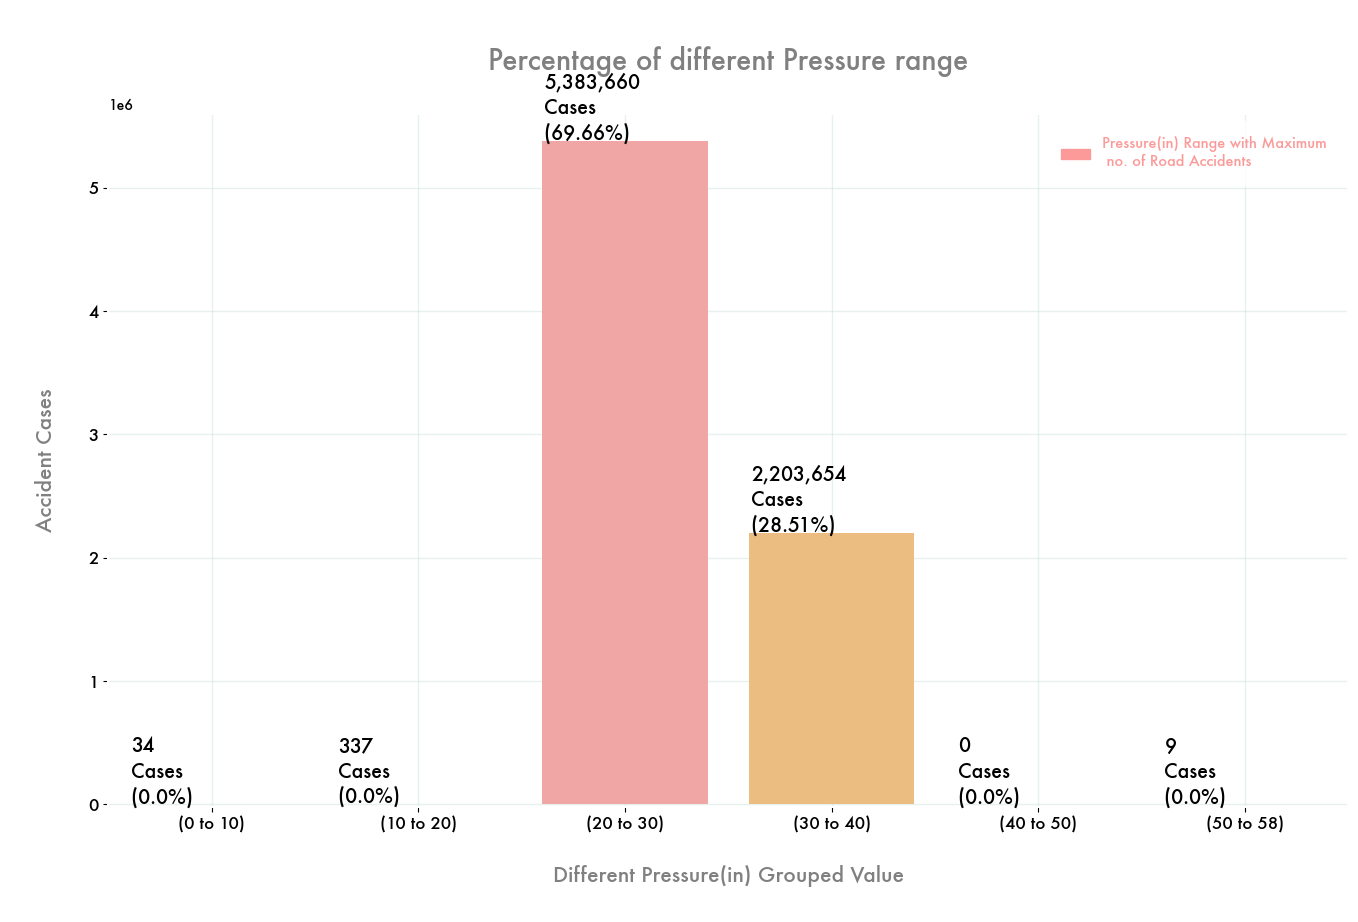

In [32]:
Pressure_intervals, Pressure_labels = generate_intervals_labels('Pressure(in)', 6, 10)

Feature_Bin_Plot(accident, 'Pressure(in)', 'Paired', Pressure_intervals, Pressure_labels, 
                 (16, 9), 14, (-20000, 5600000), [0.01, 10000], '\nPercentage of different Pressure range\n')

Different Wind_Chill(F) Grouped Value
Index(['Bins', 'Cases'], dtype='object')
Wind Chill.jpg


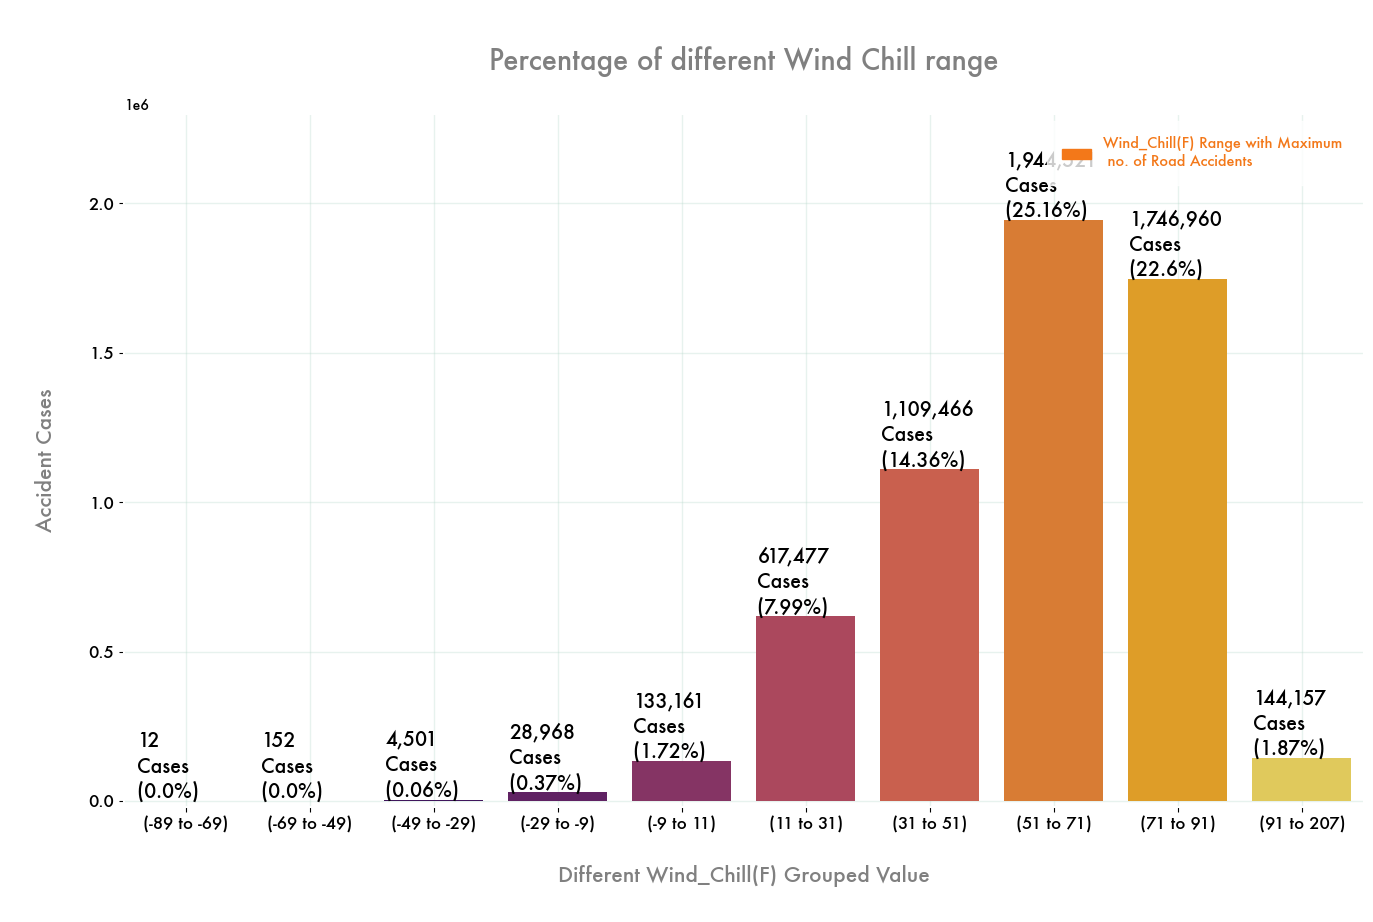

In [33]:
# accident['Wind_Chill(F)'] = accident['Wind_Chill(F)'].fillna(0)

Wind_Chill_intervals, Wind_Chill_labels = generate_intervals_labels('Wind_Chill(F)', 10, 20)

Feature_Bin_Plot(accident, 'Wind_Chill(F)', 'inferno', Wind_Chill_intervals, Wind_Chill_labels, 
                 (16, 9), 14, (-20000, 2300000), [0.01, 10000], '\nPercentage of different Wind Chill range\n')

Different Wind_Speed(mph) Grouped Value
Index(['Bins', 'Cases'], dtype='object')
Wind Speed.jpg


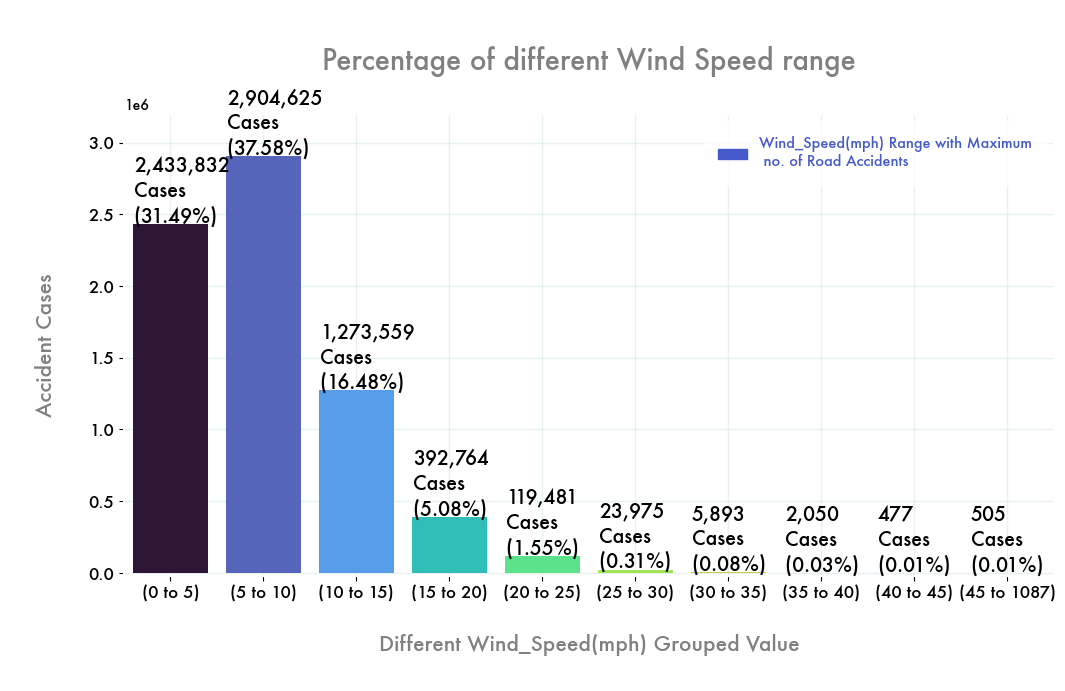

In [34]:
Wind_Speed_intervals, Wind_Speed_labels = generate_intervals_labels('Wind_Speed(mph)', 10, 5)

# accident['Wind_Chill(F)'] = accident['Wind_Chill(F)'].fillna(0)

Feature_Bin_Plot(accident, 'Wind_Speed(mph)', 'turbo',Wind_Speed_intervals, Wind_Speed_labels, 
                 (12, 6), 14, (-20000, 3200000), [0.01, 10000], '\nPercentage of different Wind Speed range\n')

Different Visibility(mi) Grouped Value
Index(['Bins', 'Cases'], dtype='object')
Visibility.jpg


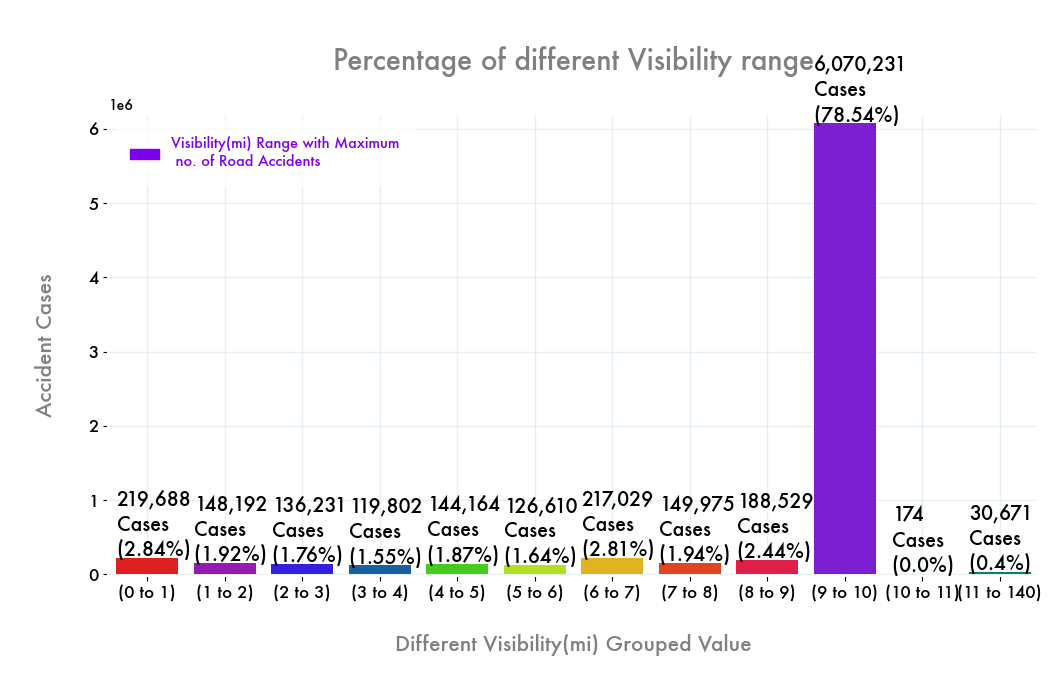

In [35]:
Visibility_intervals, Visibility_labels = generate_intervals_labels('Visibility(mi)', 12, 1)

Feature_Bin_Plot(accident, 'Visibility(mi)', 'prism', Visibility_intervals, Visibility_labels, 
                 (12, 6), 14, (-20000, 6200000), [0.01, 30000], '\nPercentage of different Visibility range\n')

In [36]:
weather_condition_df = pd.DataFrame(accident.Weather_Condition.value_counts().head(10)).reset_index().rename(columns={'count':'Cases'})
weather_condition_df

Weather_Condition    Cases
0              Fair  2560802
1     Mostly Cloudy  1016195
2            Cloudy   817082
3             Clear   808743
4     Partly Cloudy   698972
5          Overcast   382866
6        Light Rain   352957
7  Scattered Clouds   204829
8        Light Snow   128680
9               Fog    99238

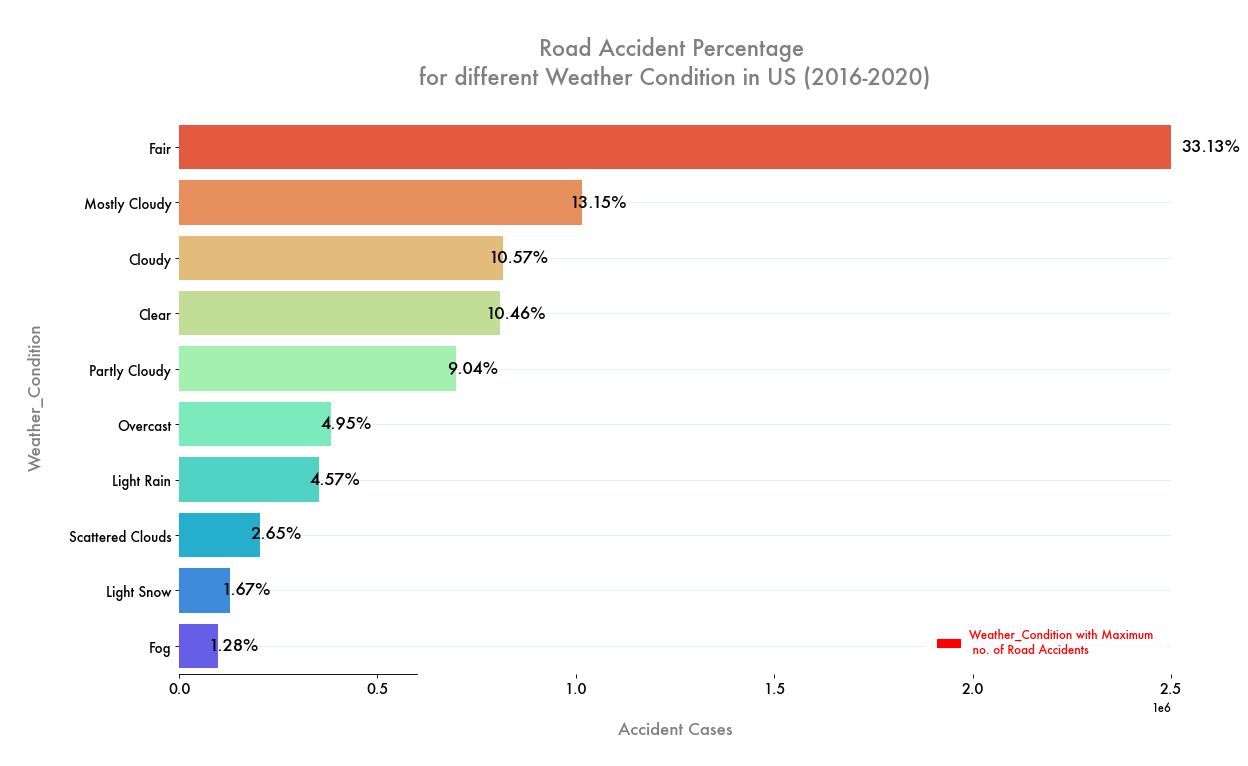

In [37]:

fig, ax = plt.subplots(figsize = (16,9), dpi = 80)

cmap = cm.get_cmap('rainbow_r', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(x=weather_condition_df['Cases'], y=weather_condition_df['Weather_Condition'], palette='rainbow_r')

total = accident.shape[0]
for p in ax.patches:
    plt.text(p.get_width()+40000, p.get_y()+0.4,
            '{:.2f}%'.format(p.get_width()*100/total),ha='center', va='center', fontsize=15, color='black', weight='bold')

plt.title('\nRoad Accident Percentage \nfor different Weather Condition in US (2016-2020)\n', size=20, color='grey')
plt.xlabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.ylabel('\nWeather_Condition\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.xlim(0, 2500000)

for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

ax.set_axisbelow(True)
ax.spines['bottom'].set_bounds(0, 600000)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)

MA = mpatches.Patch(color=clrs[0], label='Weather_Condition with Maximum\n no. of Road Accidents')
ax.legend(handles=[MA], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=[clrs[0]], edgecolor='white')

plt.savefig(os.path.join('pics','Weather condition.jpg'), bbox_inches='tight')

# Show the plot
plt.show()

## State rank

In [38]:
population = pd.read_csv(os.path.join("dataset", "population.csv"))
accident_rank = accident.groupby("State").agg({"ID": 'count'}).sort_values(by = 'ID', ascending = False).reset_index()
accident_rank = accident_rank.merge(population, left_on="State", right_on="code", suffixes=["_code", ""]).drop(columns = "code")
accident_rank['accident_ratio'] = accident_rank.ID / accident_rank.Population
accident_rank = accident_rank.sort_values(by = "accident_ratio", ascending=False).reset_index(drop=True)
accident_rank = accident_rank[["State_code", "ID"]].set_index("State_code")
accident_rank.plot.bar(figsize=(8,6))
plt.title('Count in each State')
plt.show()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 16: invalid start byte